In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [11]:
class NeuralNet(nn.Module):

    def __init__(self,
                 input_dimension,
                 output_dimension,
                 n_hidden_layers,
                 neurons,
                 regularization_param,
                 regularization_exp,
                 retrain_seed,
                 activation_name):

        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation_name = activation_name
        self.activation = self.get_activation(activation_name)
        # Regularization parameter
        self.regularization_param = regularization_param
        # Regularization exponent
        self.regularization_exp = regularization_exp
        # Random seed for weight initialization
        self.retrain_seed = retrain_seed

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers - 1)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

        self.init_xavier()

    def init_xavier(self):
        torch.manual_seed(self.retrain_seed)

        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                if self.activation_name in ['tanh', 'relu']:
                    gain = nn.init.calculate_gain(self.activation_name)
                else:
                    gain = 1
                torch.nn.init.xavier_uniform_(m.weight, gain=gain)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.regularization_exp)
        return reg_loss

    def get_activation(self, activation_name):
        if activation_name in ['tanh']:
            return nn.Tanh()
        elif activation_name in ['relu']:
            return nn.ReLU(inplace=True)
        elif activation_name in ['lrelu']:
            return nn.LeakyReLU(inplace=True)
        elif activation_name in ['sigmoid']:
            return nn.Sigmoid()
        elif activation_name in ['softplus']:
            return nn.Softplus(beta=4)
        elif activation_name in ['celu']:
            return nn.CELU()
        else:
            raise ValueError('Unknown activation function')

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

        
def fit(model, training_set, x_validation_, y_validation_, num_epochs, optimizer, p, verbose=True):
    history = [[], []]
    regularization_param = model.regularization_param

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                loss_u = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p)
                loss_reg = model.regularization()
                loss = loss_u + regularization_param * loss_reg
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item() / len(training_set)
                return loss

            optimizer.step(closure=closure)

        y_validation_pred_ = model(x_validation_)
        validation_loss = torch.mean((y_validation_pred_.reshape(-1, ) - y_validation_.reshape(-1, )) ** p).item()
        history[0].append(running_loss[0])
        history[1].append(validation_loss)

        if verbose:
            print('Training Loss: ', np.round(running_loss[0], 8))
            print('Validation Loss: ', np.round(validation_loss, 8))

    print('Final Training Loss: ', np.round(history[0][-1], 8))
    print('Final Validation Loss: ', np.round(history[1][-1], 8))
    return history

def run_single_configuration(conf_dict, x_, y_):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    print(conf_dict)

    # Get the configuration to test
    opt_type = conf_dict["optimizer"]
    n_epochs = conf_dict["epochs"]
    n_hidden_layers = conf_dict["hidden_layers"]
    neurons = conf_dict["neurons"]
    regularization_param = conf_dict["regularization_param"]
    regularization_exp = conf_dict["regularization_exp"]
    retrain_seed = conf_dict["init_weight_seed"]
    batch_size = conf_dict["batch_size"]
    activation = conf_dict["activation"]

    validation_size = int(20 * x_.shape[0] / 100)
    training_size = x_.shape[0] - validation_size
    x_train = x_[:training_size, :]
    y_train = y_[:training_size, :]

    x_val = x_[training_size:, :]
    y_val = y_[training_size:, :]

    training_set = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

    my_network = NeuralNet(input_dimension=x_.shape[1],
                           output_dimension=y_.shape[1],
                           n_hidden_layers=n_hidden_layers,
                           neurons=neurons,
                           regularization_param=regularization_param,
                           regularization_exp=regularization_exp,
                           retrain_seed=retrain_seed,
                           activation_name=activation)

    if opt_type == "ADAM":
        optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
    elif opt_type == "LBFGS":
        optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    history = fit(my_network, training_set, x_val, y_val, n_epochs, optimizer_, p=2, verbose=False)

    y_val = y_val.reshape(-1, )
    y_train = y_train.reshape(-1, )

    y_train_pred = my_network(x_train).reshape(-1,)
    y_val_pred = my_network(x_val).reshape(-1,)
    
    relative_error_train = torch.mean((y_train_pred - y_train) ** 2) / torch.mean(y_train ** 2)
    print('Relative Training Error:', relative_error_train.detach().numpy() ** 0.5 * 100, '%')
    
    relative_error_val = torch.mean((y_val_pred - y_val) ** 2) / torch.mean(y_val ** 2)
    print('Relative Validation Error:', relative_error_val.detach().numpy() ** 0.5 * 100, '%')
    
    plt.figure(figsize=(16, 8))
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1,n_epochs+1), history[0], label="Training Loss")
    plt.plot(np.arange(1,n_epochs+1), history[1], label="Validation Loss")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()
    
#     plt.figure(figsize=(16, 8))
#     plt.grid(True, which="both", ls=":")
#     plt.scatter(x_train[:,0], y_train, label="Training Data", marker="o", color="C0")
#     plt.scatter(x_val[:,0], y_val, label="Validation Data", marker="*", color="C1", s=100)
#     plt.scatter(x_test[:,0], y_test_pred.detach(), label="Network Prediction",lw=2, color="black", ls="-.")
#     plt.xlabel("x")
#     plt.ylabel("u")
#     plt.legend()
#     plt.show()
    
    return my_network

In [12]:
def fit_(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = [[], []]
    regularization_param = model.regularization_param

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                loss_u = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, )) ** p)
                loss_reg = model.regularization()
                loss = loss_u + regularization_param * loss_reg
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item() / len(training_set)
                return loss

            optimizer.step(closure=closure)

        history[0].append(running_loss[0])
        history[1].append(0)

        if verbose:
            print('Training Loss: ', np.round(running_loss[0], 8))
            print('Validation Loss: ', np.round(validation_loss, 8))

    print('Final Training Loss: ', np.round(history[0][-1], 8))
    print('Final Validation Loss: ', np.round(history[1][-1], 8))
    return history

def run_single_configuration_(conf_dict, x_, y_):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    print(conf_dict)

    # Get the configuration to test
    opt_type = conf_dict["optimizer"]
    n_epochs = conf_dict["epochs"]
    n_hidden_layers = conf_dict["hidden_layers"]
    neurons = conf_dict["neurons"]
    regularization_param = conf_dict["regularization_param"]
    regularization_exp = conf_dict["regularization_exp"]
    retrain_seed = conf_dict["init_weight_seed"]
    batch_size = conf_dict["batch_size"]
    activation = conf_dict["activation"]

    training_set = DataLoader(torch.utils.data.TensorDataset(x_, y_), batch_size=batch_size, shuffle=True)

    my_network = NeuralNet(input_dimension=x_.shape[1],
                           output_dimension=y_.shape[1],
                           n_hidden_layers=n_hidden_layers,
                           neurons=neurons,
                           regularization_param=regularization_param,
                           regularization_exp=regularization_exp,
                           retrain_seed=retrain_seed,
                           activation_name=activation)

    if opt_type == "ADAM":
        optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
    elif opt_type == "LBFGS":
        optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    history = fit_(my_network, training_set, n_epochs, optimizer_, p=2, verbose=False)

    y_train = y_.reshape(-1,)
    y_train_pred = my_network(x_).reshape(-1,)
    
    relative_error_train = torch.mean((y_train_pred - y_train) ** 2) / torch.mean(y_train ** 2)
    print('Relative Training Error:', relative_error_train.detach().numpy() ** 0.5 * 100, '%')
    
    plt.figure(figsize=(16, 8))
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1,n_epochs+1), history[0], label="Training Loss")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()
    
    return my_network

In [13]:
with open('TrainingData.txt', 'r') as f:
    data = []
    lines = f.readlines()
    for line in lines:
        words = line.split(' ')
        data.append([float(words[0]), float(words[1]), float(words[2])])
    data = np.array(data)

n_samples = data.shape[0]
np.random.seed(42)
np.random.shuffle(data)

In [14]:
t = data[:,0]
t_max = t.max()
t = torch.from_numpy(t.reshape(-1,1) / t_max).float()

u = data[:,1]
u_max = u.max()
u = torch.from_numpy(u.reshape(-1,1) / u_max).float()

t_u = torch.hstack((t, u))

tf = torch.from_numpy(data[:,2].reshape(-1,1)).float()

#################### 0 ####################
{'epochs': 3000, 'hidden_layers': 5, 'neurons': 10, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 567, 'activation': 'tanh'}
Final Training Loss:  2.18e-06
Final Validation Loss:  2.64e-06
Relative Training Error: 0.062379270093515515 %
Relative Validation Error: 0.06690733134746552 %


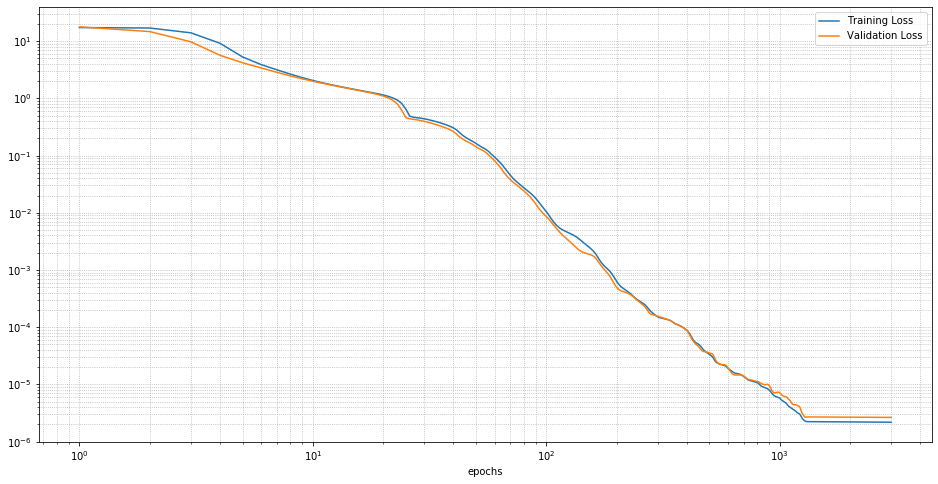

#################### 1 ####################
{'epochs': 3000, 'hidden_layers': 5, 'neurons': 10, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 34, 'activation': 'tanh'}
Final Training Loss:  1.25e-06
Final Validation Loss:  1.11e-06
Relative Training Error: 0.04721610457636416 %
Relative Validation Error: 0.04337441059760749 %


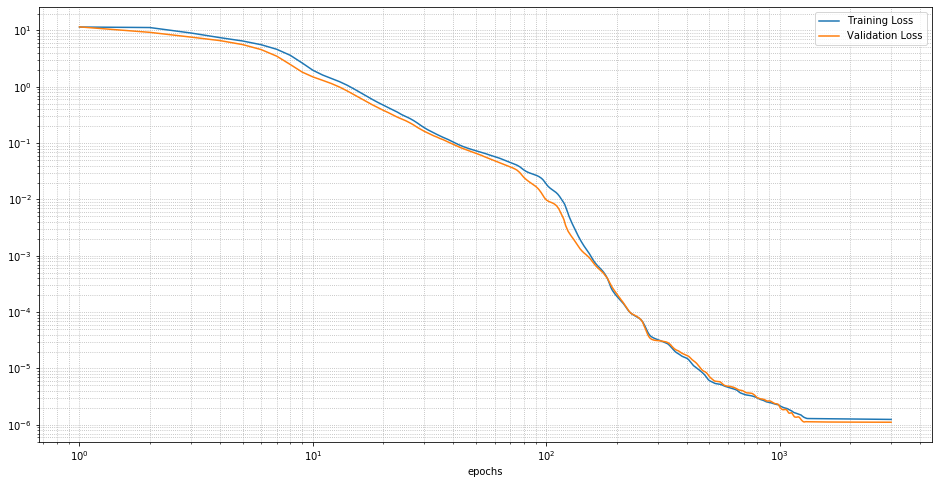

#################### 2 ####################
{'epochs': 3000, 'hidden_layers': 5, 'neurons': 10, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 134, 'activation': 'tanh'}
Final Training Loss:  9.5e-07
Final Validation Loss:  1.16e-06
Relative Training Error: 0.04118903598282486 %
Relative Validation Error: 0.04433789581526071 %


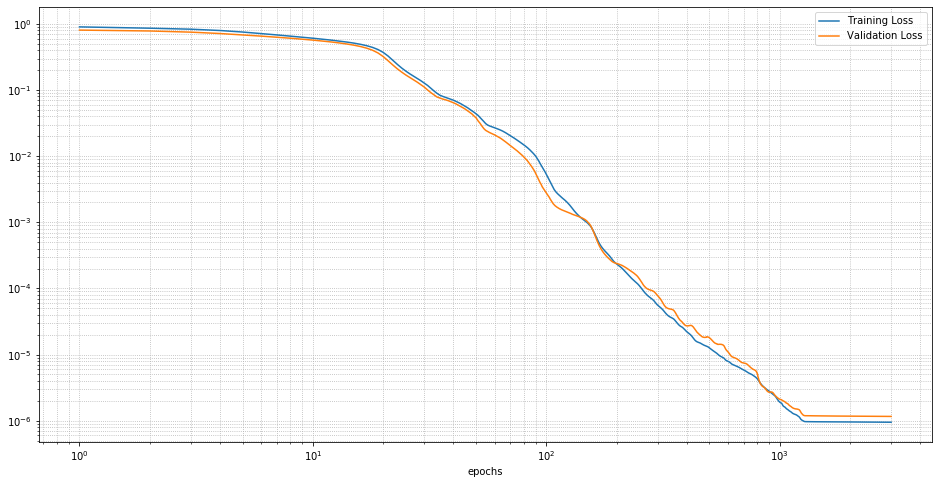

#################### 3 ####################
{'epochs': 3000, 'hidden_layers': 5, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 567, 'activation': 'tanh'}
Final Training Loss:  2.77e-06
Final Validation Loss:  2.62e-06
Relative Training Error: 0.07040109485387802 %
Relative Validation Error: 0.06663494277745485 %


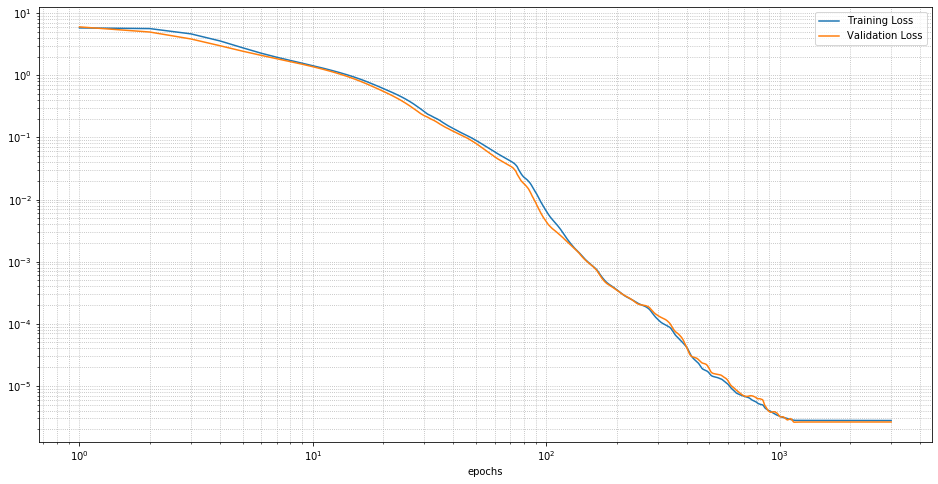

#################### 4 ####################
{'epochs': 3000, 'hidden_layers': 5, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 34, 'activation': 'tanh'}
Final Training Loss:  1.09e-06
Final Validation Loss:  9.8e-07
Relative Training Error: 0.04413217830006033 %
Relative Validation Error: 0.04082253435626626 %


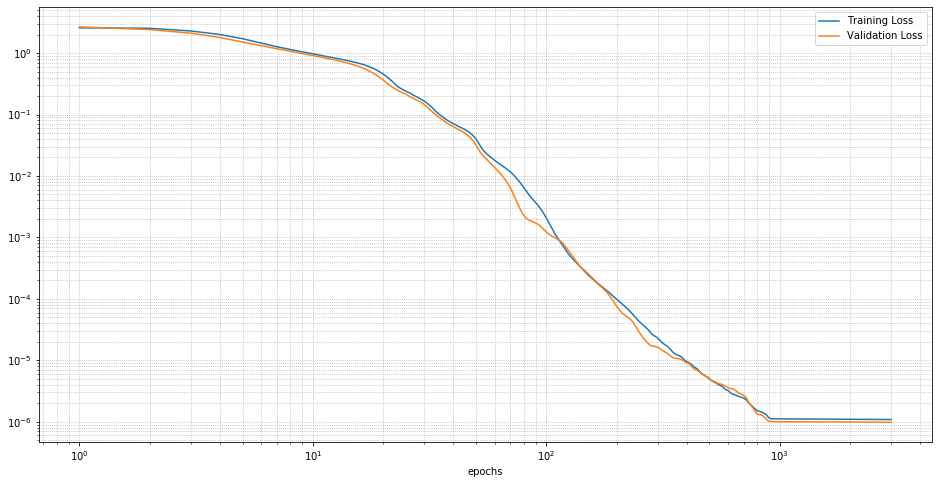

#################### 5 ####################
{'epochs': 3000, 'hidden_layers': 5, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 134, 'activation': 'tanh'}
Final Training Loss:  1.51e-06
Final Validation Loss:  1.48e-06
Relative Training Error: 0.051947939209640026 %
Relative Validation Error: 0.05000790115445852 %


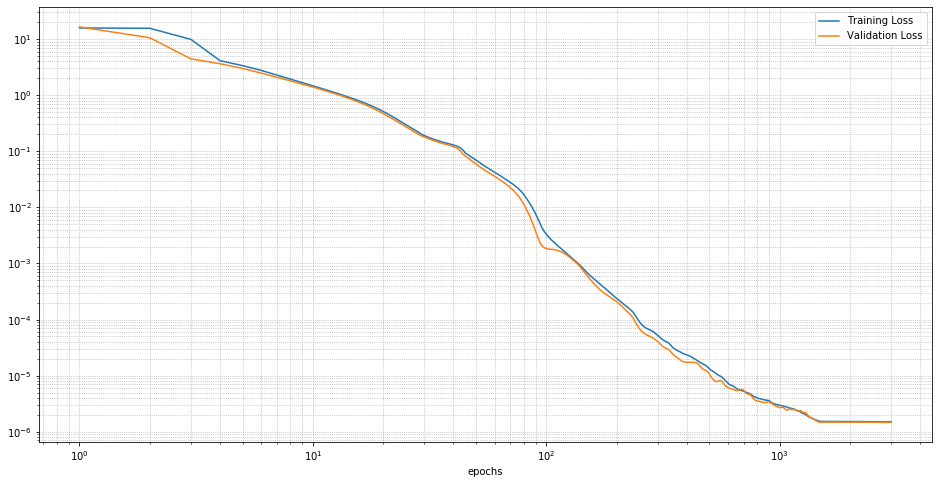

#################### 6 ####################
{'epochs': 3000, 'hidden_layers': 10, 'neurons': 10, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 567, 'activation': 'tanh'}
Final Training Loss:  1.93e-06
Final Validation Loss:  3.06e-06
Relative Training Error: 0.058762001572176814 %
Relative Validation Error: 0.0719918345566839 %


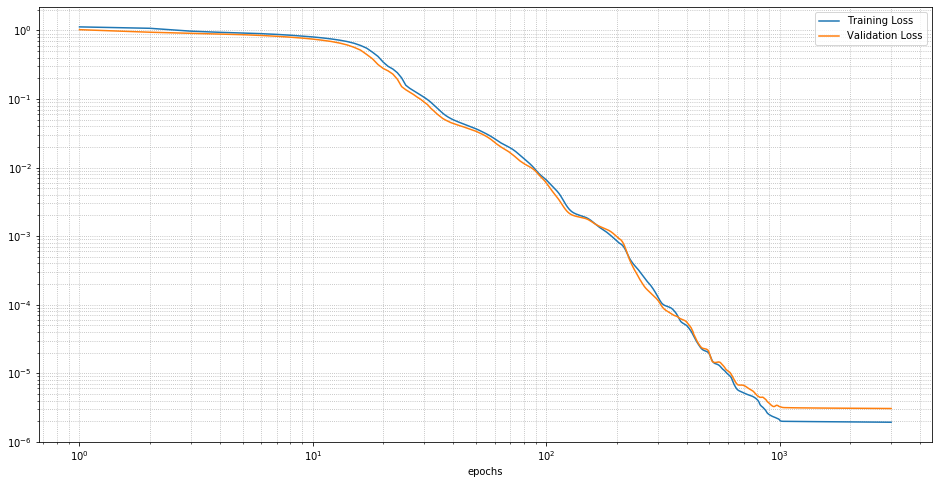

#################### 7 ####################
{'epochs': 3000, 'hidden_layers': 10, 'neurons': 10, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 34, 'activation': 'tanh'}
Final Training Loss:  3.33e-06
Final Validation Loss:  3.37e-06
Relative Training Error: 0.07718665874563158 %
Relative Validation Error: 0.07556702475994825 %


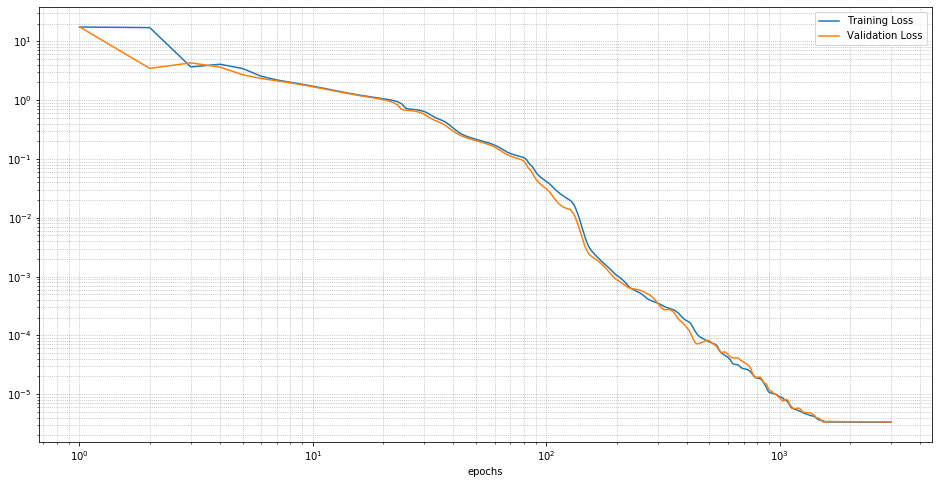

#################### 8 ####################
{'epochs': 3000, 'hidden_layers': 10, 'neurons': 10, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 134, 'activation': 'tanh'}
Final Training Loss:  1.48e-06
Final Validation Loss:  1.43e-06
Relative Training Error: 0.051458977395668626 %
Relative Validation Error: 0.04926540423184633 %


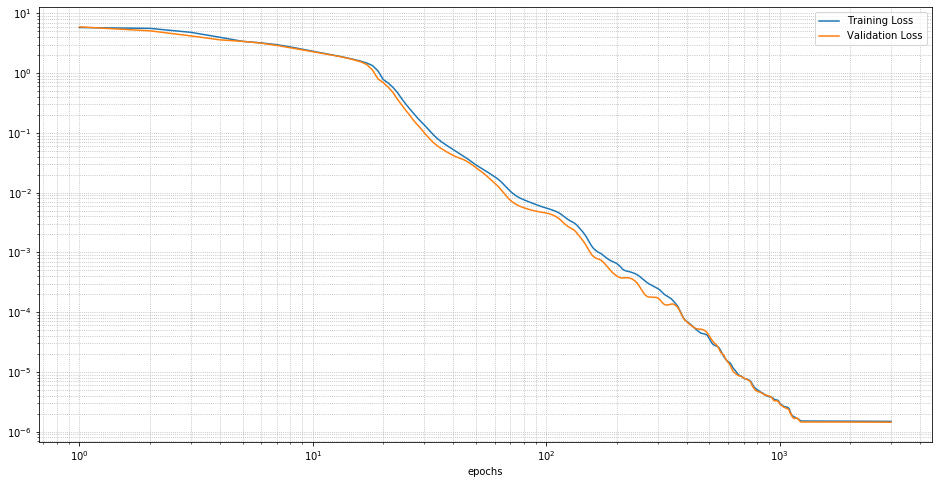

#################### 9 ####################
{'epochs': 3000, 'hidden_layers': 10, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 567, 'activation': 'tanh'}
Final Training Loss:  7.5e-07
Final Validation Loss:  9.4e-07
Relative Training Error: 0.03658676578197628 %
Relative Validation Error: 0.039860187098383904 %


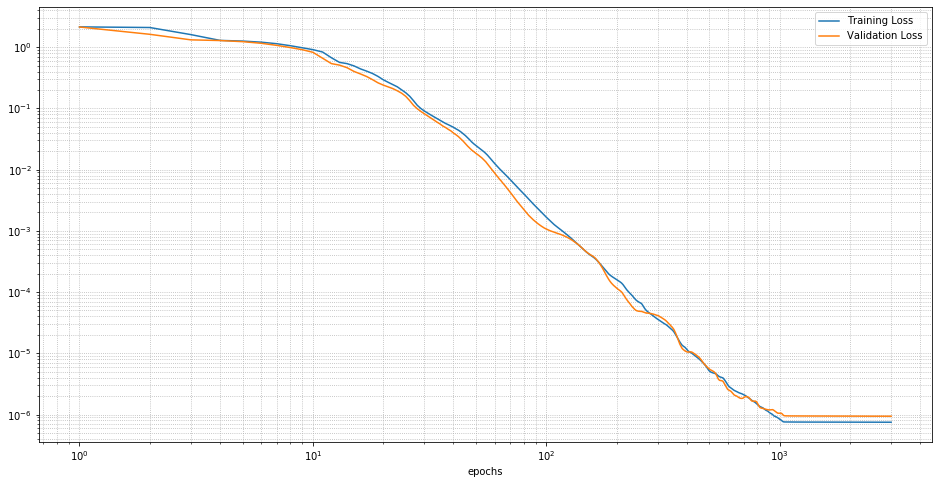

#################### 10 ####################
{'epochs': 3000, 'hidden_layers': 10, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 34, 'activation': 'tanh'}
Final Training Loss:  1.07e-06
Final Validation Loss:  1.19e-06
Relative Training Error: 0.043787542381323874 %
Relative Validation Error: 0.044842661009170115 %


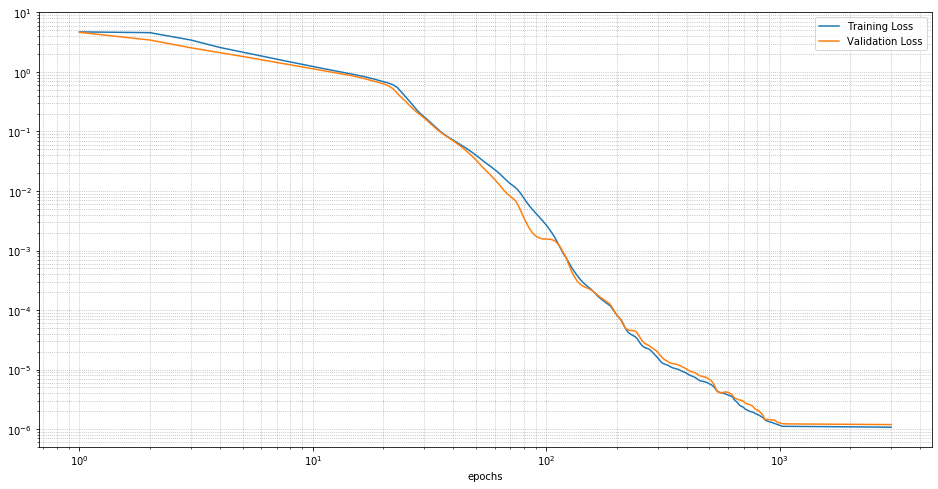

#################### 11 ####################
{'epochs': 3000, 'hidden_layers': 10, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 134, 'activation': 'tanh'}
Final Training Loss:  1.01e-06
Final Validation Loss:  9.4e-07
Relative Training Error: 0.04245183081366122 %
Relative Validation Error: 0.03995563311036676 %


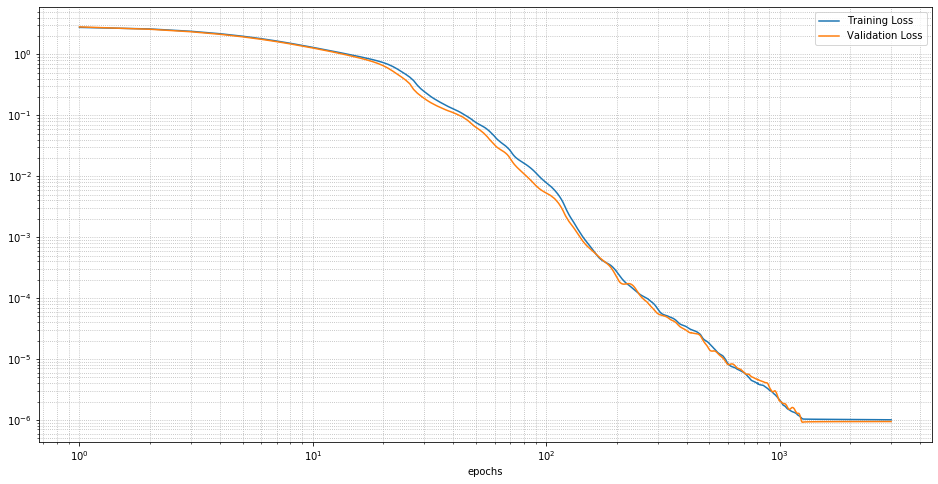

In [15]:
hyperparameters_configurations = {
    "epochs": [3000],
    "hidden_layers": [5, 10],
    "neurons": [10, 20],
    "regularization_exp": [2],
    "regularization_param": [0],
    "batch_size": [n_samples],
    "optimizer": ["LBFGS"],
    "init_weight_seed": [567, 34, 134],
    "activation": ["tanh"]
}

settings = list(itertools.product(*hyperparameters_configurations.values()))

for set_num, setup in enumerate(settings):
    print('####################', set_num, '####################')
    setup_properties = {
        'epochs': setup[0],
        'hidden_layers': setup[1],
        'neurons': setup[2],
        'regularization_exp': setup[3],
        'regularization_param': setup[4],
        'batch_size': setup[5],
        'optimizer': setup[6],
        'init_weight_seed': setup[7],
        'activation': setup[8]
    }
    
    run_single_configuration(setup_properties, t_u, tf)

{'epochs': 2000, 'hidden_layers': 5, 'neurons': 20, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 1024, 'optimizer': 'LBFGS', 'init_weight_seed': 34, 'activation': 'tanh'}
Final Training Loss:  1.39e-06
Final Validation Loss:  0
Relative Training Error: 0.049506028881296515 %


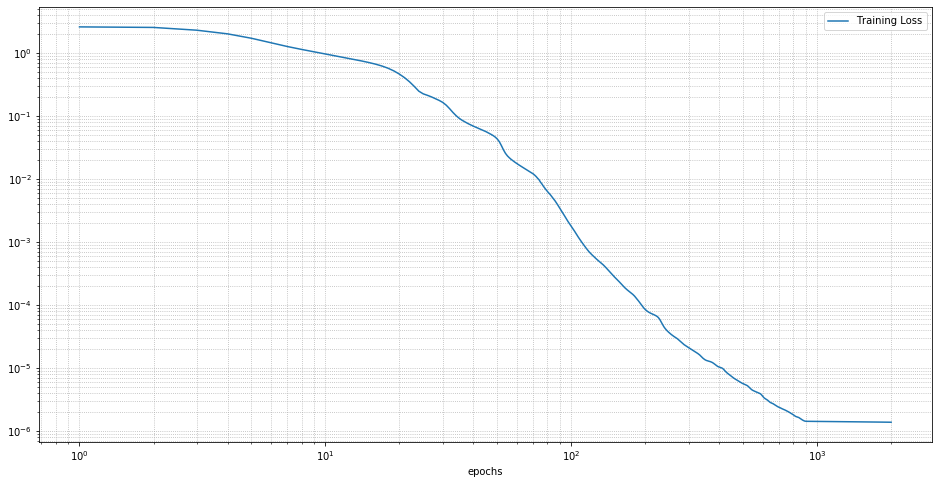

In [16]:
setup_properties = {
    'epochs': 2000,
    'hidden_layers': 5,
    'neurons': 20,
    'regularization_exp': 2,
    'regularization_param': 0,
    'batch_size': n_samples,
    'optimizer': 'LBFGS',
    'init_weight_seed': 34,
    'activation': 'tanh'
}

Tf_model = run_single_configuration_(setup_properties, t_u, tf)

In [17]:
with open('MeasuredDataFull.txt', 'r') as f:
    data_measured = []
    lines = f.readlines()
    for line in lines:
        words = line.split(' ')
        data_measured.append([float(words[0]), float(words[1]), float(words[2])])
    data_measured = np.array(data_measured)
    
n_measured = data_measured.shape[0]

In [18]:
t_measured = torch.from_numpy(data_measured[:,0].reshape(-1,1) / t_max).float()
tf_measured = data_measured[:,1].reshape(-1,)
sigma = data_measured[:,2].reshape(-1,)

In [19]:
resolution = 50000
u_sample = np.linspace(0, 1, resolution)
G = []
for i in range(resolution):
    u = u_sample[i]
    u_tensor = torch.tensor(u).expand(n_measured, 1).float()
    Tf_star = Tf_model(torch.hstack((t_measured, u_tensor))).detach().numpy().reshape(-1,)
    G.append(np.mean(((tf_measured - Tf_star) / sigma) ** 2))
    
u_star = u_sample[np.argmin(G)] * u_max
print(u_star)
with open('Task4b.txt', 'w') as f:
    f.write(f'{u_star:.18f}')

15.261457217116941


4c

In [20]:
train = pd.read_csv('TrainingData.txt',sep=' ',header=None)
measured_data = pd.read_csv('MeasuredData.txt',sep=' ',header=None)

In [21]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from pyro.infer import MCMC, NUTS, HMC
from torch.distributions import MultivariateNormal
import pickle
import numpy as np
import pandas as pd
import os

In [22]:
def f(data):
    # Corresponds to G(x, w) from the notes, mean of gaussian likelihood
    pred_mean = Tf_model(data).detach().reshape(1,-1)[0]
    return pred_mean

In [37]:
# Define the prior and the likelihood according to pyro syntax
mu_prior = 12.
sigma_prior = 4 #np.sqrt(4)
sigma_likelihood = 0.075 #np.sqrt(0.075)


def model(t, T):
    # Prior is a gaussian distriubtion with mean 0 and standard deviation 0.1
    prior_u = dist.Normal(mu_prior, sigma_prior)
    u = pyro.sample("u", prior_u)
    u = u.expand(t.shape[0], 1)
    inputs = torch.cat([t, u/u_max], 1)
    mean = Tf_model(inputs)
    # Likelihood is a gaussian distriubtion with mean G(x,w)=wx and standard deviation 0.1
    likelihood = dist.Normal(mean, sigma_likelihood)
    T_sampled = pyro.sample("obs", likelihood, obs=T)


In [38]:
n_samples = 1000

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=n_samples, warmup_steps=1000, initial_params={"u": torch.tensor(mu_prior)})
mcmc.run(t_measured, torch.from_numpy(tf_measured.reshape(-1,1)).float())
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}



Sample: 100%|██████████| 2000/2000 [00:12, 164.63it/s, step size=1.19e+00, acc. prob=0.880]


Text(0.5, 1.0, 'MCMC Trace')

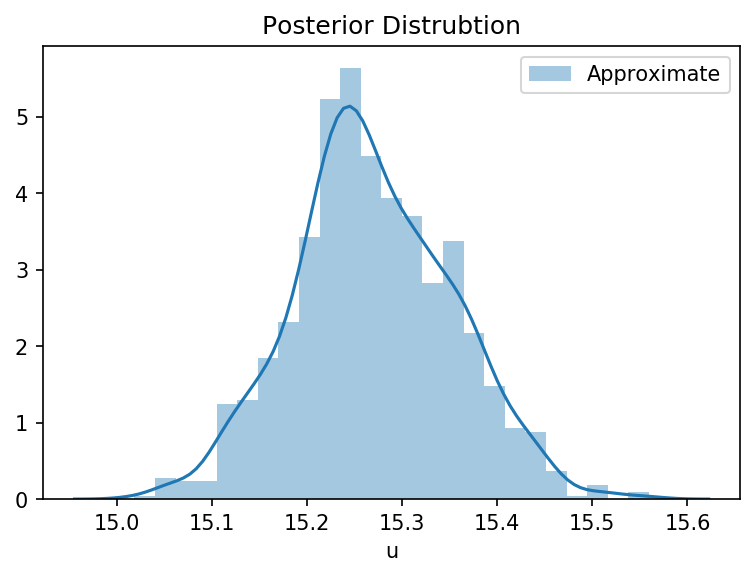

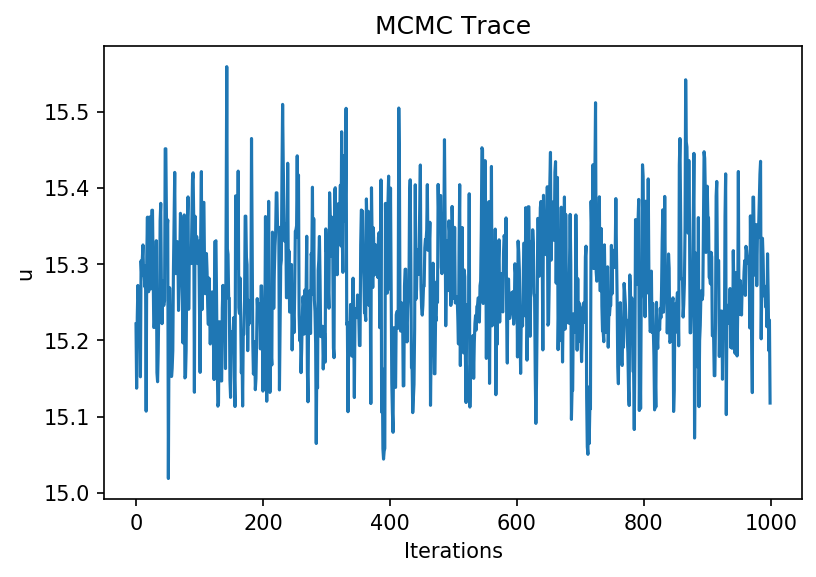

In [40]:
plt.figure(dpi=150)
sns.distplot(hmc_samples["u"], label="Approximate", norm_hist=True)
plt.xlabel("u")
plt.title("Posterior Distrubtion")
plt.legend()
plt.figure(dpi=150)
plt.plot(np.arange(0, hmc_samples["u"].shape[0]), hmc_samples["u"], label="MCMC")
plt.ylabel("u")
plt.xlabel("Iterations")
plt.title("MCMC Trace")

In [41]:
np.savetxt('/Users/chenyilu/SynologyDrive/ETH2_2/DLSC/projects/Project2B 2/Task4/Task4c.txt', hmc_samples["u"])